In [8]:
# See en.wikipedia.org/wiki/De_Casteljau's_algorithm and https://pomax.github.io/bezierinfo/
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def bezier(points: np.ndarray, t: float) -> np.ndarray:
    """Compute a point on a Bezier curve.

    Args:
        points: A 2D array of shape (n, 2) containing the control points.
        t: The parameter value at which to compute the point in [0, 1].

    Returns:
        A 1D array of shape (2,) containing the point on the curve.
    """
    n = points.shape[0] - 1
    if n == 0:
        return points[0]
    corner_cut_points = np.empty((n, 2))
    for i in range(n):
        current_point = points[i]
        vec_to_next_point = points[i + 1] - current_point
        corner_cut_points[i] = current_point + t * vec_to_next_point
    return bezier(corner_cut_points, t)

def bezier_curve(points: np.ndarray, num_points: int = 100) -> np.ndarray:
    """Compute a Bezier curve.

    Args:
        points: A 2D array of shape (n, 2) containing the control points.
        num_points: The number of points to compute on the curve.

    Returns:
        A 2D array of shape (num_points, 2) containing the points on the curve.
    """
    return np.array([bezier(points, t) for t in np.linspace(0, 1, num_points)]) 

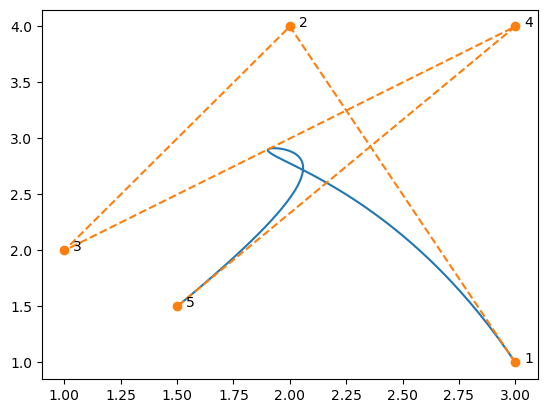

In [20]:
# draw a random ass shape
points = np.array([[3, 1], [2, 4], [1, 2], [3, 4], [1.5, 1.5]])
curve = bezier_curve(points)
plt.plot(curve[:, 0], curve[:, 1])
plt.plot(points[:, 0], points[:, 1], "o--")
for i, point in enumerate(points):
    plt.text(point[0] + 0.04, point[1], i+1)
plt.show()
